In [53]:
import numpy as np
import matplotlib
import ase as ase
from ase import units
from ase import Atoms
from ase.build import molecule
from ase.visualize import view
from ase.md.verlet import VelocityVerlet
from ase.calculators.morse import MorsePotential
from ase.md.velocitydistribution import (MaxwellBoltzmannDistribution,
                                         Stationary, ZeroRotation)
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import ipywidgets as widgets
from IPython.display import display, clear_output

## <span style="color:#F6A800"> I. Equations of motion </span>

In molecular dynamics (MD) simulations, one studies the motion of a system in time by propagating it according to an algorithm which solves some equations of motion. For example, these could be **Newton's equations of motion**,

$$ m\ddot{{\bf r}} = {\bf F} = -\nabla U(r)$$

with mass $m$, positions $\bf r$, and force $\bf F$, which can be written as the negative gradient of the potential $U$. The dot is a notation for the derivative with respect to time, _i.e._, $\dot{\bf r}=\dfrac{\partial {\bf r}}{\partial t}$ and $\ddot{\bf r}=\dfrac{\partial^2 {\bf r}}{\partial t^2}$.

In order to derive a time propagation algorithm, one can consider the Taylor expansion of second order of the positions $\bf r$:
$$ {\bf r}(t+\Delta t) = {\bf r}(t)+\dot{{\bf r}}(t)\Delta t + \frac{1}{2}\ddot{{\bf r}}(t)\Delta t^2 +\mathcal{O}(\Delta t^3)  $$ 
Analogeous, 
$$ {\bf r}(t-\Delta t) = {\bf r}(t)-\dot{{\bf r}}(t)\Delta t + \frac{1}{2}\ddot{{\bf r}}(t)\Delta t^2 -\mathcal{O}(\Delta t^3)  $$ 

When adding these two equations and neglecting the higher order terms, we obtain

$$ \boxed{{\bf r}(t+\Delta t) = 2{\bf r}(t)-{\bf r}(t-\Delta t)+\ddot{{\bf r}}(t)\Delta t^2} $$

which is called the **Verlet** algorithm and can be used to calculate the positions at the next time step $t+\Delta t$, given the positions at the previous two time steps, and the forces of the previous time step (remember that: ${\rm F}=m\ddot{\rm r}$).

A commonly used algorithm for propagating the system in time, *i.e.*, simulating its dynamics, is the use of the **Velocity Verlet** algorithm, where positions and velocities (remember: ${\bf v} = \dot{{\bf r}}$) are updated in every time step:

$$ \boxed{{\bf r}(t+\Delta t) = {\bf r}(t)+\dot{{\bf r}}(t)\Delta t + \frac{1}{2}\ddot{{\bf r}}(t)\Delta t^2} $$
$$ \boxed{\dot{{\bf r}}(t+\Delta t) = \dot{{\bf r}}(t)+\frac{1}{2} \left[ \ddot{{\bf r}}(t)+\ddot{{\bf r}}(t+\Delta t) \right]\Delta t} $$

Here, only knowledge on the previous time step is required for the updates of the positions. After the position update, the forces of the current time step (and, hence, $\ddot{{\bf r}}(t+\Delta t)$) is calculated, which is then used to update the velocities.

## <span style="color:#F6A800"> II. Intramolecular interactions </span>

### <span style="color:#F6A800"> II.1. Morse potential </span>
    
Intramolecular interactions can be fitted to a Morse potential:

$$ U_{\rm morse} = D \cdot \Bigl( 1- \exp\left[ -\alpha \cdot (r-r_0)\right] \Bigl)^2$$

The parameters $D$ and $r_0$ are called dissociation energy and equilibrium distance, respectively, and $\alpha$ represents the curvature.

In [54]:
def morse_potential(D,r0,alpha):
    r = np.arange(0.8, 3.5, 0.001)
    morse = D*(1-np.exp(-alpha*(r-r0)))**2
    plot_morse = plt.plot(r,morse,lw=2,color='#000000',label="morse")

def fitting_morse(D,r0,alpha):
    plt.figure(figsize=(20,10))
    plt.rcParams.update({'font.size':20})
    
    plt.subplot(1, 2, 1)
    plt.xlim([0.8,3.5])
    plt.ylim([-0.001,160])
    plt.xlabel(r'$r$ (arb.u.)')
    plt.ylabel(r'$U_{\rm morse}(r)$ (arb.u.)')
    plt.title("Morse potential")
    morse_potential(D,r0,alpha)
    
    plt.subplot(1, 2, 2)
    plt.xlim([0.8,1.8])
    plt.ylim([-0.001,20])
    plt.xlabel(r'$r$ (arb.u.)')
    plt.ylabel(r'$U_{\rm morse}(r)$ (arb.u.)')
    plt.title('Morse potential'+' (zoomed)')
    morse_potential(D,r0,alpha)

In [ ]:
morse = widgets.interactive(fitting_morse, 
                         D=widgets.FloatSlider(min=80., max=300., step=10., value=150, \
                                               description="$D$"),
                         r0=widgets.FloatSlider(min=0.8, max=1.2, step=0.01, value=1.0, \
                                                description="$r_0$"),
                         alpha=widgets.FloatSlider(min=1.0, max=2.5, step=0.1, value=1.5, \
                                                   description=r"$\alpha$")
                        )
display(morse)



### <span style="color:#F6A800"> II.2 Harmonic bond potential </span>

The Morse potential is often replaced by a harmonic bond potential 
$$U_{\rm harm} = k \Bigl( r - r_0 \Bigl)^2$$

$r_0$ is again the equilibrium distance, $k$ is called force constant. This approximation only works near the equilibrium distance.


Now, we fit the Morse potential using the harmonic bond potential to confirm our findings. First define the harmonic potential.

In [66]:
def harmonic_bond_potential(k,r0):
    r = np.arange(0.8, 1.8, 0.001)
    harmonic = k * (r-r0)**2
    plot_harmonic = plt.plot(r,harmonic,'--',lw=2,color='#DD4814',label="harmonic")

def fitting_harmonic(k,r0):
    plt.figure(figsize=(20,10))
    plt.rcParams.update({'font.size':20})
    
    plt.subplot(1, 2, 1)
    plt.xlabel(r'$r$ ($\AA$)')
    plt.ylabel(r'$U(r)$ (kJ/mol)')
    plt.ylim([-0.001,160])
    plt.xlim([0.8,3.5])
    plt.title("Morse and harmonic potentials")
    morse_potential(150,1,1.5)
    harmonic_bond_potential(k,r0)
    plt.legend()
     
    plt.subplot(1, 2, 2)
    plt.xlim([0.8,1.8])
    plt.ylim([-0.001,10])
    plt.title("Harmonic potential")
    morse_potential(150,1,1.5)
    harmonic_bond_potential(k,r0)
    plt.xlabel(r'$r$ ($\AA$)')
    plt.ylabel(r'$U(r)$ (kJ/mol)')
    plt.title('Morse and harmonic potentials'+' (zoomed)')
    plt.legend()

In [ ]:
harm = widgets.interactive(fitting_harmonic, 
                         k=widgets.FloatSlider(min=80, max=700., step=5, value=120., \
                                               description="$k$"),
                         r0=widgets.FloatSlider(min=0.8, max=1.2, step=0.01, value=1.0, \
                                                description="$r_0$")
                        )
display(harm)

## <span style="color:#F6A800"> III. Simulating carbon monoxide </span>

We will setup a very simple MD simulation of a carbon monoxide in gas phase. Let's have a look at our molecule in an interactive plot, where you can rotate the molecule (left click + move the mouse) and zoom in (mouse wheel).

In [68]:
# define molecule
NVE_system = molecule('CO')
view(NVE_system, viewer="x3d")

The bonding interaction between the carbon and the oxygen will be modeled by a Morse potential with the parameters taken from literature [Phys. Scr. 97 (2022) 035401].

In [70]:
eps = 10.85*units.eV
r0  = 1.1282*units.Ang
rho0= 2.2994/units.Ang
NVE_system.calc = MorsePotential(epsilon=eps, r0=r0, rho0=rho0)

We use the Velocity Verlet algorithm for propagating our system in time, using a time step of 0.5 fs.

In [71]:
# Setting the time step
delta_t = 0.5
dyn_NVE = VelocityVerlet(NVE_system, timestep=delta_t * units.fs)

evolved time:  0.000 fs      Epot:  0.047 eV     Ekin:  0.129 eV      Etot:  0.176 eV
evolved time:  0.500 fs      Epot:  0.021 eV     Ekin:  0.155 eV      Etot:  0.176 eV
evolved time:  1.000 fs      Epot:  0.005 eV     Ekin:  0.171 eV      Etot:  0.176 eV
evolved time:  1.500 fs      Epot:  0.000 eV     Ekin:  0.176 eV      Etot:  0.176 eV
evolved time:  2.000 fs      Epot:  0.006 eV     Ekin:  0.170 eV      Etot:  0.176 eV
evolved time:  2.500 fs      Epot:  0.022 eV     Ekin:  0.154 eV      Etot:  0.176 eV
evolved time:  3.000 fs      Epot:  0.045 eV     Ekin:  0.131 eV      Etot:  0.177 eV
evolved time:  3.500 fs      Epot:  0.073 eV     Ekin:  0.104 eV      Etot:  0.177 eV
evolved time:  4.000 fs      Epot:  0.101 eV     Ekin:  0.076 eV      Etot:  0.177 eV
evolved time:  4.500 fs      Epot:  0.128 eV     Ekin:  0.049 eV      Etot:  0.177 eV
evolved time:  5.000 fs      Epot:  0.151 eV     Ekin:  0.026 eV      Etot:  0.177 eV
evolved time:  5.500 fs      Epot:  0.167 eV     Ekin:

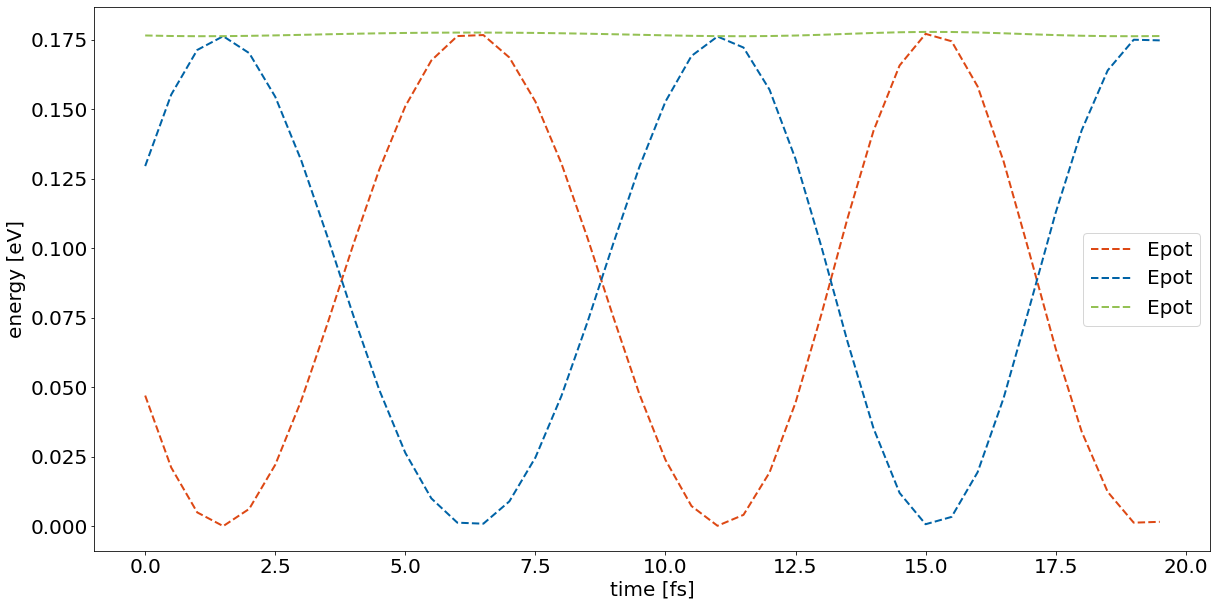

In [86]:
# Starting a new MD
def MD_initialize(temperature, Tsim):
    # Now the two atoms get velocities according to a Maxwell-Boltzmann distribution at that temperature.
    MaxwellBoltzmannDistribution(NVE_system, temperature_K=temperature)
    Stationary(NVE_system)    # zero linear momentum  <=> remove overall translation
    ZeroRotation(NVE_system)  # zero angular momentum <=> remove overall rotation
    # => complete kinetic energy is in the vibration of the CO-bond 

    # calculate maximum number of time step and initialize time series
    Tstep = round(Tsim/delta_t)
    time = []
    Epot = []
    Ekin = []
    Etot = []
    return Tstep, time, Epot, Ekin, Etot
  
# current energies    
def MD_energies(atoms):    
    current_Epot = atoms.get_potential_energy()+eps
    current_Ekin = atoms.get_kinetic_energy()
    current_Etot = atoms.get_total_energy()+eps
    return current_Epot, current_Ekin, current_Etot
        
# report for each MD step
def MD_report(current_time, current_Epot, current_Ekin, current_Etot):
    time.append(current_time)
    Epot.append(current_Epot)
    Ekin.append(current_Ekin)
    Etot.append(current_Etot)
    print("evolved time: %6.3f fs      Epot: %6.3f eV     Ekin: %6.3f eV      Etot: %6.3f eV"%(current_time,current_Epot,current_Ekin,current_Etot))
    return None

#######################################################################################################
Tsim = 20.
temperature = 300.          
Tstep, time, Epot, Ekin, Etot = MD_initialize(temperature,Tsim)              
          
for i in range(Tstep):
    current_Epot, current_Ekin, current_Etot = MD_energies(NVE_system)    
    MD_report(i*delta_t,current_Epot, current_Ekin, current_Etot)


    dyn_NVE.run(1)
  
plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size':20})
plt.plot(time,Epot,'--',lw=2,color='#DD4814',label="Epot")
plt.plot(time,Ekin,'--',lw=2,color='#0063A6',label="Epot")
plt.plot(time,Etot,'--',lw=2,color='#94C154',label="Epot")

plt.legend()
plt.xlabel("time [fs]")
plt.ylabel("energy [eV]")
plt.show()